In [67]:
import pandas as pd
import networkx as nx
import numpy as np

# Read in the CSV files

# 0.1%
accounts_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230505183351_53313/PS_20230505183351_53313_account_attributes.csv")
transactions_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230505183351_53313/PS_20230505183351_53313_rawLog.csv")

# 0.5%
#accounts_df = pd.read_csv("../datasets/p_0_5_percent/PS_20230509175835_53313/PS_20230509175835_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_0_5_percent/PS_20230509175835_53313/PS_20230509175835_53313_rawLog.csv")

# 1%
#accounts_df = pd.read_csv("../datasets/p_1_percent/PS_20230509180228_53313/PS_20230509180228_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_1_percent/PS_20230509180228_53313/PS_20230509180228_53313_rawLog.csv")

# 5%
#accounts_df = pd.read_csv("../datasets/p_5_percent/PS_20230509180753_53313/PS_20230509180753_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_5_percent/PS_20230509180753_53313/PS_20230509180753_53313_rawLog.csv")





In [68]:
nodes_df = accounts_df
edges_df = transactions_df


nodes_df.head()
edges_df.head()

,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
0,1,CASH_IN,100243.81,C3711514457,51165.26,151409.07,M2139508901,0.0,0.00,0,0,0
1,1,PAYMENT,6806.93,C2983091074,94.07,-6712.87,M6107049916,0.0,6806.93,0,0,0
2,1,CASH_IN,4150.20,C8693153668,39.18,4189.38,M3661435444,0.0,0.00,0,0,0
3,1,CASH_IN,116530.77,C8693153668,4189.38,120720.15,M5095935565,0.0,0.00,0,0,0
4,1,CASH_IN,180533.34,C6847049600,230174.65,410707.99,M9361279418,0.0,0.00,0,0,0


In [69]:
# create dummies for the 'action' column
dummies = pd.get_dummies(edges_df.action, prefix='action')

# concatenate the dummies to the original DataFrame
edges_df = pd.concat([edges_df, dummies], axis=1)

# drop the original 'action' column
edges_df.drop('action', axis=1, inplace=True)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,1,100243.81,C3711514457,51165.26,151409.07,M2139508901,0.0,0.00,0,0,0,True,False,False,False,False
1,1,6806.93,C2983091074,94.07,-6712.87,M6107049916,0.0,6806.93,0,0,0,False,False,False,True,False
2,1,4150.20,C8693153668,39.18,4189.38,M3661435444,0.0,0.00,0,0,0,True,False,False,False,False
3,1,116530.77,C8693153668,4189.38,120720.15,M5095935565,0.0,0.00,0,0,0,True,False,False,False,False
4,1,180533.34,C6847049600,230174.65,410707.99,M9361279418,0.0,0.00,0,0,0,True,False,False,False,False


In [70]:
# Now we compute numerical indices for nameOrig and nameDest rather than their form 'CC6839167080'

# Create a dictionary that maps each unique original name to a new unique ID
node_ids = {node_name: i for i, node_name in enumerate(set(edges_df['nameOrig']).union(set(edges_df['nameDest'])))}


# Replace the original names with the new IDs
edges_df['nameOrig'] = edges_df['nameOrig'].map(node_ids)
edges_df['nameDest'] = edges_df['nameDest'].map(node_ids)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,1,100243.81,38341,51165.26,151409.07,3399,0.0,0.00,0,0,0,True,False,False,False,False
1,1,6806.93,12688,94.07,-6712.87,42443,0.0,6806.93,0,0,0,False,False,False,True,False
2,1,4150.20,8766,39.18,4189.38,15445,0.0,0.00,0,0,0,True,False,False,False,False
3,1,116530.77,8766,4189.38,120720.15,31696,0.0,0.00,0,0,0,True,False,False,False,False
4,1,180533.34,2374,230174.65,410707.99,16532,0.0,0.00,0,0,0,True,False,False,False,False


In [71]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.0.1+cu118


In [72]:
x_np = nodes_df.to_numpy()
x = x_np[:,0:-3]
x.shape

(55544, 41)

In [73]:
from torch.utils.data import random_split
# Define your graph
x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
edge_index =  torch.stack([torch.tensor(edges_df.nameOrig.to_numpy()),torch.tensor(edges_df.nameDest.to_numpy())],dim=-1).T  # Define your edge index
edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
y =  torch.tensor(nodes_df.node_isFraud.to_numpy().astype(int),dtype=torch.long) # target values

# Bitflip the tensor
#y = y ^ torch.tensor([1], dtype=torch.uint8).expand_as(y)


train_size = int(0.6 * len(y))  # 60% of the dataset for training
val_size = int(0.2 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

In [74]:
from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data.to(device)

Data(x=[55544, 41], edge_index=[2, 3785960], edge_attr=[3785960, 12], y=[55544], train_mask=[55544], val_mask=[55544], test_mask=[55544])

In [75]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 55544
Number of edges: 3785960
Average node degree: 68.16
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Is weighted: False
Number of training nodes: 33326
Training node label rate: 0.60


In [76]:
from models.MPNN import GNN_MPNN_Model
from models.SAGE import GNN_SAGE_Model
from models.CONV import GNN_CONV_Model
from torch_geometric.nn import Sequential, GAT, GIN

In [77]:
HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 2 #@param

dataset_num_features = x.size()[1]
dataset_num_classes = 2

# Message Passing Neural Network
model = GNN_MPNN_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GraphSAGE
#model = GNN_SAGE_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# CONV
#model = GNN_CONV_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GAT
#model = GAT(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_features)

# GIN
model = GIN(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_features)

model.to(device)
model.eval()

out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

In [80]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

criterion = torch.nn.CrossEntropyLoss()
#criterion = CrossEntropyFocalLoss(gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      out = model(data.x, data.edge_index)
      #print(len(out[data.train_mask]),len(data.y[data.train_mask]))
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      #loss = sigmoid_focal_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

print("epoch,train_loss,validation_loss")
st = time.time()
for epoch in range(1, 301):
    train_loss = train()
    val_loss, _, _ = test(data.val_mask)
    
    #print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - ' f'Validation accuracy: {val_loss * 100:.2f}%')
    print(str(epoch) + ',' + str(train_loss.item()) + ',' + str(val_loss*100))
et = time.time()
elapsed_time = et - st
print("Time for", epoch, "epochs is", elapsed_time, "seconds")

<IPython.core.display.Javascript object>

epoch train_loss validation_loss
1 0.06920454651117325 37.810586964350016
2 8.476642608642578 87.71155923658624
3 0.5921281576156616 98.67662945624774
4 0.14466632902622223 98.67662945624774
5 0.2426590621471405 98.67662945624774
6 0.32314562797546387 98.67662945624774
7 0.38812389969825745 98.67662945624774
8 0.4370720088481903 98.67662945624774
9 0.47113701701164246 98.67662945624774
10 0.4911990463733673 98.67662945624774
11 0.4975479543209076 98.67662945624774
12 0.49143779277801514 98.67662945624774
13 0.47322455048561096 98.67662945624774
14 0.4436355233192444 98.67662945624774
15 0.4034358859062195 98.67662945624774
16 0.3575795888900757 98.67662945624774
17 0.3046715259552002 98.67662945624774
18 0.24453815817832947 98.67662945624774
19 0.17767377197742462 98.67662945624774
20 0.10725658386945724 39.47605329492258
21 1.2787834405899048 98.67662945624774
22 0.09625725448131561 98.67662945624774
23 0.15600937604904175 98.67662945624774
24 0.21405400335788727 98.67662945624774
25 

In [58]:
def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

In [64]:
test_acc, test_out, test_pred  = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 98.69%


In [65]:
out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

tensor(0)
tensor(0.0131)
Precision: 0.00
Recall: 0.00
F1-score: 0.00


d:\anaconda\envs\anaconda\envs\GDL2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


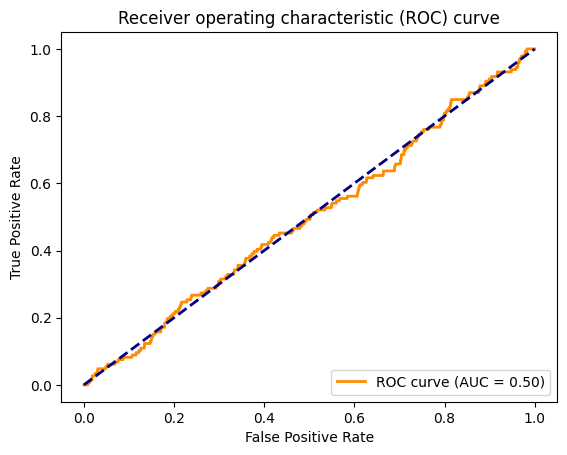

In [66]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import torch.nn.functional as F

y_true = data.y[data.test_mask].cpu()
y_pred = softmax_x = F.softmax(test_out, dim=1)
test_pred = y_pred.argmax(dim=1).detach().cpu()
y_pred = y_pred[:, 1].detach().cpu().numpy()
print(torch.sum(test_pred))
print(torch.sum(y_true)/y_true.shape[0])


# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, test_pred, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [58]:
fpr, tpr, roc_auc

df_model = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_model.to_csv('results/GAT_5.csv', index=False)